In [1]:
!pip install pycuda

  Using cached pycuda-2025.1.2.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pytools-2025.2.5-py3-none-any.whl (98 kB)
  Using cached siphash24-1.8-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (103 kB)
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp310-cp310-linux_x86_64.whl size=661012 sha256=121b57808da08129bbd2fe7df6234f33443026839a86b11dae8ad6410f0c4bbf
  Stored in directory: /home/section/.cache/pip/wheels/b6/0d/37/bc8f63a8bb69cb1dcaccde7a783855c3ac91925eaa0c044817
Successfully built pycuda


In [2]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from PIL import Image
import time
import matplotlib.pyplot as plt

RuntimeError: cuInit failed: no CUDA-capable device is detected

In [70]:
#Define the CUDA C kernel

cuda_kernel_source= """
// The input image is encoded as unsigned chars [0,255]
// Each pixel is 3 consecutive charsfor the 3 channel (RGB)
__global__ void colrtoGrayscaleConversion (unsigned char * Pout, unsigned char * Pin, int width, int height)
{
  int CHANNELS =3;
  int col = blockIdx.x*blockDim.x+threadIdx.x;
  int row = blockIdx.y*blockDim.y+threadIdx.y;

  if (col<width && row<height)
  {
    // Get 1D offset for thr grayscale image
    int grayOffset = row*width + col;
    // One can think of RGB image having CHANNEL
    // times more columns than the grayscale image
    int rgbOffset = grayOffset*CHANNELS;
    unsigned char r = Pin[rgbOffset ];
    unsigned char g = Pin[rgbOffset + 1];
    unsigned char b = Pin[rgbOffset + 2];

    //Perform the rescaling and store it
    //We multiply by floating point constants
    Pout[grayOffset] = 0.21f*r + 0.71f*g +0.07f*b;
  }
}"""

In [71]:
print('compiling the CUDA C Kenel....')
#Compile the CUDA Kernel
mod = SourceModule(cuda_kernel_source)

#Get the kernel function from thr compile module
colortograyconverter=mod.get_function("colrtoGrayscaleConversion")

print("kernel compiled successfully")

compiling the CUDA C Kenel....
kernel compiled successfully


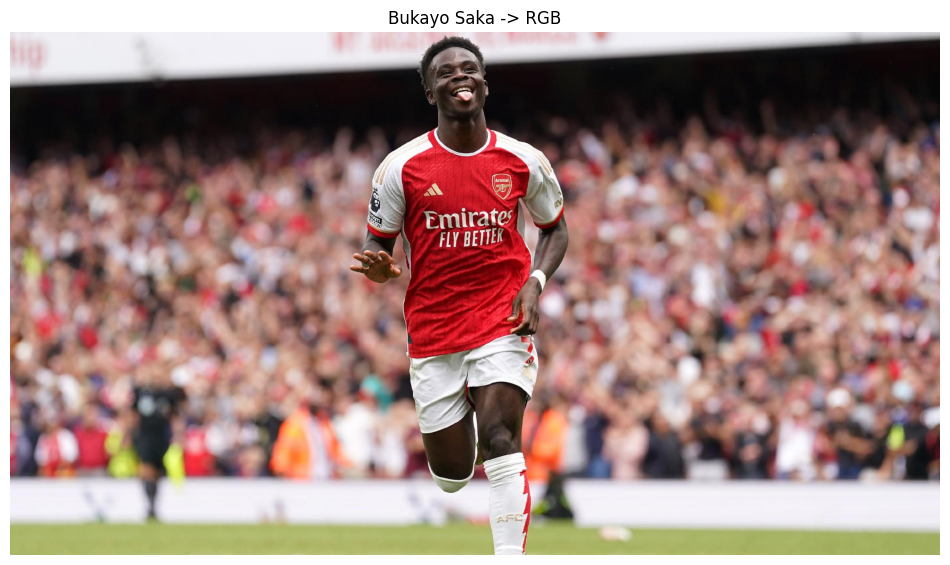


The matrix of Bukayo Saka is initialised now


In [72]:
#Load the image and show the image
image = np.array(Image.open('1696296-bukayo-saka-nets-stunner-before-arsenal-forced-to-cling-on-to-beat-forest.jpg'))
axes=plt.figure(figsize=(12,10))
plt.imshow(image,)
plt.axis('off')
plt.title('Bukayo Saka -> RGB')
plt.show()
print('\nThe matrix of Bukayo Saka is initialised now')

In [73]:
print(f'The shape of the matrix is {image.shape}')

#intialise an empty array for gpu to store the grayscale result

gpu_empty_result_grid= np.empty_like(image[0:,0:,0])
print("Output Matrix initialised")

The shape of the matrix is (1080, 1920, 3)
Output Matrix initialised


In [74]:
#Allocate the memory on the gpy
p_in =cuda.mem_alloc(image.nbytes)
p_out=cuda.mem_alloc(gpu_empty_result_grid.nbytes)

print('Memory allocated for GPU')


Memory allocated for GPU


In [75]:
#Transfer the data from CPU to GPU
print('copying the image from CPU to GPU')
cuda.memcpy_htod(p_in,image)
print('Image is successfully copied to device')

copying the image from CPU to GPU
Image is successfully copied to device


In [76]:
#Excute the kernel in GPU
print("\n Executing the parallel programming code for gray scale conversion in GPU")

# Define the block and the Grid Dimension for the GPU.
# A block is a group of  threads . A grid is a group of blocks

BLOCK_SIZE=(16,16,1)
GRID_SIZE=(
    (image.shape[0]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0],
    (image.shape[1]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0]
    )

#Start the timer
start_time_gpu= time.time()

#Call the Kernel
colortograyconverter(
    p_out,p_in,np.int32(image.shape[0]),np.int32(image.shape[1]),
    block=BLOCK_SIZE,
    grid=GRID_SIZE)

#Wait for the GPU to Finish the Process
cuda.Context.synchronize()

#stop the timer
stop_time_gpu= time.time()

gpu_time=stop_time_gpu-start_time_gpu
print(f"The execution completed successfully. time taken {gpu_time}")




 Executing the parallel programming code for gray scale conversion in GPU
The execution completed successfully. time taken 0.00033402442932128906


In [77]:
#Copying the output back to CPU
print("\n Copying the result from GPU to CPU...")
cuda.memcpy_dtoh(gpu_empty_result_grid,p_out)
print("\n Data transferred back to CPU...")



 Copying the result from GPU to CPU...

 Data transferred back to CPU...


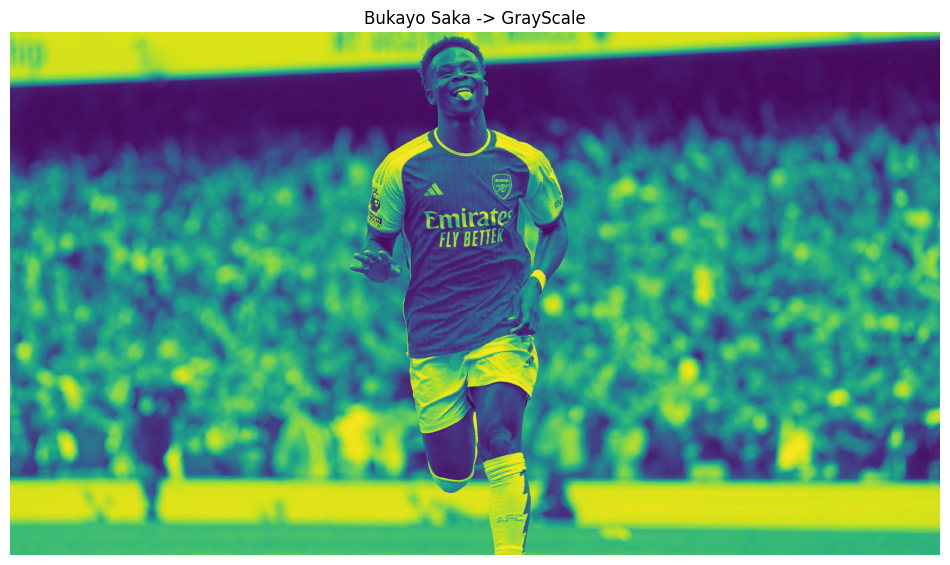


Bukayo Saka From GPU


In [78]:
axes=plt.figure(figsize=(12,10))
plt.imshow(gpu_empty_result_grid,)
plt.axis('off')
plt.title('Bukayo Saka -> GrayScale')
plt.show()
print('\nBukayo Saka From GPU')

In [79]:
#Performing the same operation in CPU

#initializing the result array in cpu
result = np.zeros(image.shape[0:2])
print('Starting execution in cpu...',end="")

cpu_start_time= time.time()
for i in range(0,image.shape[0]):
  for j in range(0,image.shape[1]):
    result[i,j]= 0.21*image[i,j,0] + 0.71*image[i,j,1] +0.07*image[i,j,2]
cpu_end_time= time.time()

cpu_execution_time=cpu_end_time-cpu_start_time

print('completed')


Starting execution in cpu...completed


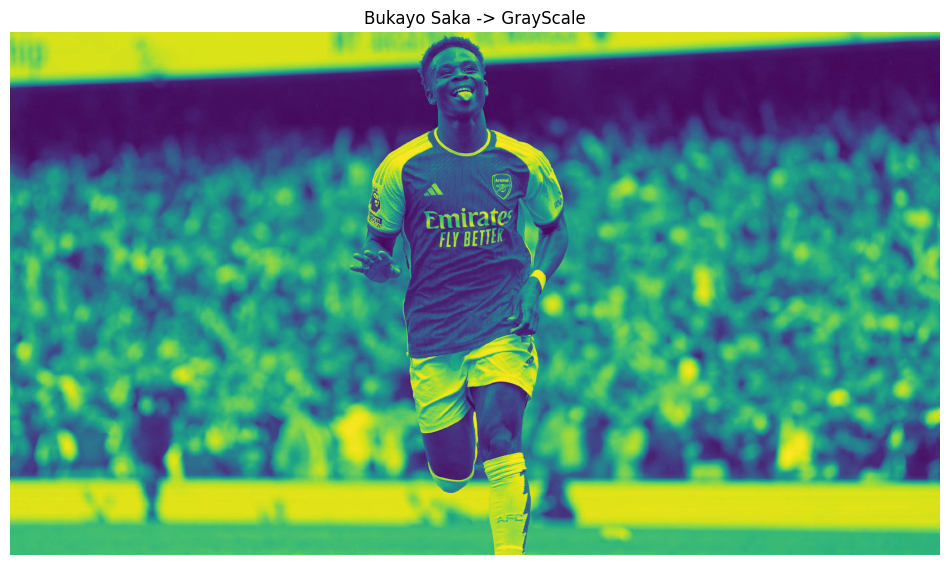


Bukayo Saka From CPU


In [80]:
axes=plt.figure(figsize=(12,10))
plt.imshow(result,)
plt.axis('off')
plt.title('Bukayo Saka -> GrayScale')
plt.show()
print('\nBukayo Saka From CPU')

In [83]:
print(f"Time taken in GPU is {gpu_time} \nTime taken in CPU is {cpu_execution_time}")

Time taken in GPU is 0.00033402442932128906 
Time taken in CPU is 18.469489812850952
